**To execute this notebook it's necessary to install the required dependencies:**

1. [Savime](https://github.com/hllustosa/Savime/). run the script `examples/test_savime.sh` to verify if the installing process was successful.
2. Some Python modules are displayed in `tutorial.yml`. The easiest way to install them is to use the Anaconda package manager [Anaconda](https://www.anaconda.com/) and create a new enviroment with the command
    - `conda env create -f tutorial.yml`
    - To activate the enviroment, run `conda activate tutorial`
3. [pysavime](https://github.com/dnasc/PySavime): Use the previously defined enviroment. It won't be necessary to install the suggested packages in PySavime repository. 
4. [TFX](https://www.tensorflow.org/tfx/serving/setup): In Ubuntu, run `sudo apt install tensorflow-model-server`. If using another OS, follow this [tutorial](https://www.tensorflow.org/tfx/serving/setup).

# Part 01

In this first notebook, we will generate multiple models, all of them are adapted from [Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization). These will be used on notebooks 2 and 3. 
To generate the models, we will take the following steps: 

1. Define a learning function (where $d$ is the number of *features*).
$$\begin{align}y &= f(x)\\f: X &\to Y, X \subset \mathbb{R}^d, Y \subset \mathbb{R}\end{align}$$
2. Generate an uniform sample (dataset) $D_X \subset X$.
3. Generate $D_Y$ from $D_X$ and $D = concat(D_X, D_Y)$.
4. Train $m$ (regressor) models $m_i: X \to Y$. Each model $m_i$ must be
trained (train / test/ validation) in one partition from $D^{(i)} = (D_X^{(i)}, D_Y^{(i)}) \subset D$ so that:
$$D = \bigcup_{i=1}^{m} D^{(i)} \;,\; \bigcap_{i=1}^{m} D^{(i)} = \emptyset \; \land \;  i < j \implies \forall x_i \in D_X^{(i)}, x_j \in D_X^{(j)} \left(x_i < x_j \right)$$
5. Use a metric $\phi$ and evaluate each model $m_i$ in each partition $D^{(j)}$.
Here $\phi$ is defined as the mean squared error between the prediction and the true value.
6. Save the models in a appropriat format to posterior call from Tfx. Save $D$ in order to be registered in Savime. 

## Definition of $f$:

The definition of $f$ requires that we define some parameters:

- $ X = [\rm {low}, \rm{high}]$;
- $ D_X = (x_1, ..., x_n), x_i \sim U(X)$, where $n$ is the number of observations.
- $D_Y = (f(x),  x \in D_X)$.
- $ D = (D_X, D_Y) $ is partitioned into $m$ partitions $D^{(i)}$ each associated with a $m_i$ model.
- $ A = \rm{linspace} (\alpha_{min} = 1, \alpha_{max} = 3, \rm{num\_partitions} = m) $is an ordered and equally
spaced from numbers between 1 and 3 and size equal to $m$. Each $ d_i $ is associated to an $\alpha_i \in A$.
- $ g (x) $ indicates which $\alpha$ should be associated to $x$. For example, if $ X = [-1, 1] $,
and $ m = 2 $ then $ A = [1, 3] $, $ g (x = -. 5) = 1 $ and $ g (x = .5) = 3 $.
- $ f (x) = g (x_1) x_1 + ... + g (x_d) x_d + \varepsilon $, where
$ \varepsilon \sim \mathcal{N}(\mu, \sigma) $ (e.g., $\mu = 0 $ and $ \sigma = 1 $).
- *Note that $ f $ is a collection of linear functions each associated with an $ X $ partition.

In [3]:
%load_ext autoreload
%autoreload 2

import inspect
import os
import random as rn

if not 'notebooks' in os.listdir('.'):
    current_dir = os.path.abspath(os.getcwd())
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)
    
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from src.functions import f2_x as f
from src.model import ElasticNet, ModelFactory
from src.util import plot_heatmap

# Reproductibility
import numpy as np
import random as rn
import tensorflow as tf

seed = 32
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Paired"))

tf.get_logger().setLevel('ERROR')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


As an example, the behavior of $f$ is shown below. Note that (i) the function domain is $[- 1, 1]$, (ii) the number of partitions is 5, and (iii) the five alphas (coefficients) associated with the partitions are [-1, -0.5, 0, 0.5, 1]. Note also that the function has a stochastic component ($ \varepsilon \in \mathcal {N} \left (0, \frac {1} {10} \right)$):

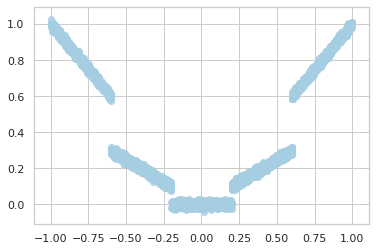

In [2]:
low_plot, high_plot, num_partitions_plot = -1, 1, 5
x_plot = np.random.uniform(low_plot, high_plot, 10000).reshape(-1, 1)
y_plot = f(x_plot, low_plot, high_plot, num_partitions_plot, 0, .01,
              alpha_min=-1, alpha_max=1)
sns.regplot(x_plot.ravel(), y_plot.ravel(), fit_reg=False)

To train the models, we will use the following configurations:
- **Number of features** = 2
- **Number of models and partitions** = 25
- **Observations**:
  - number_of_observations = 100000
  - Range = [-1, 1]
- **Model adjustment**:
   - Percentage of training, validation and testing respectively equal to .5, .3 and .2.
- **Function**:
   - Alphas ranging between 1 and 3.
   - Error $\varepsilon \in \mathcal{N} (0, 0.01)$

In [2]:
# number of features, observations and models
d = 2
n = 100000
m = 25

# Model's Input shape 
input_shape = (d, )

# X interval
low = -1
high = 1

# uniform sample between low and high of size n*d
x = np.random.uniform(low, high, n * d)

# Ordering x to get item 4
x = np.reshape(np.sort(x), newshape=(n, d))

# Model training configurations
val_size = .3
test_size = .2

# Name prefix associated to each model
model_name_prefix = 'my_elastic_net'

# Where model and data are stored
output_dir = os.path.join(parent_dir, 'saved_models_elastic_net')

# Function Configuration
f_alpha_min = 1 
f_alpha_max = 3
f_mean = 0
f_std = 10e-2

**In the cell below, a model factory is instantiated. The factory ('model_factory') will be responsible for:**
1. Create the vector y based on the function f described previously;
2. Divide x into m partitions;
3. Train each model in its proper partition;
4. Train a model across all the domain;
5. Save the models;
6. Save the data.

In [4]:
f_config = dict(low=low, high=high, num_partitions=m, mean=f_mean, std=f_std,
                alpha_min=f_alpha_min, alpha_max=f_alpha_max)

model_config = dict(input_shape=input_shape, loss=tf.keras.losses.mean_squared_error, 
                    metrics=[tf.keras.metrics.mean_squared_error],epochs=10)

model_factory = ModelFactory(model_class=ElasticNet, x=x, f_x=f, num_models=m,
                             test_size=test_size, val_size=val_size,
                             model_name_prefix=model_name_prefix,
                             f_kwargs=f_config, model_kwargs=model_config)

model_factory.build_models()
model_factory.fit_models()

Building models: 100%|██████████| 25/25 [00:01<00:00, 13.20it/s]
Training models by partition: 25it [01:08,  2.72s/it]
Training a model in the whole domain: 100%|██████████| 1/1 [00:56<00:00, 56.86s/it]


Next we calculate the each models mean squared error on each partition and on the complete domain.

In [5]:
# Saving model and data
info = model_factory.get_metric_info()

model_factory.save_models(output_dir)
model_factory.save_data(output_dir, info)

Building metric matrices: 26it [02:39,  6.14s/it]


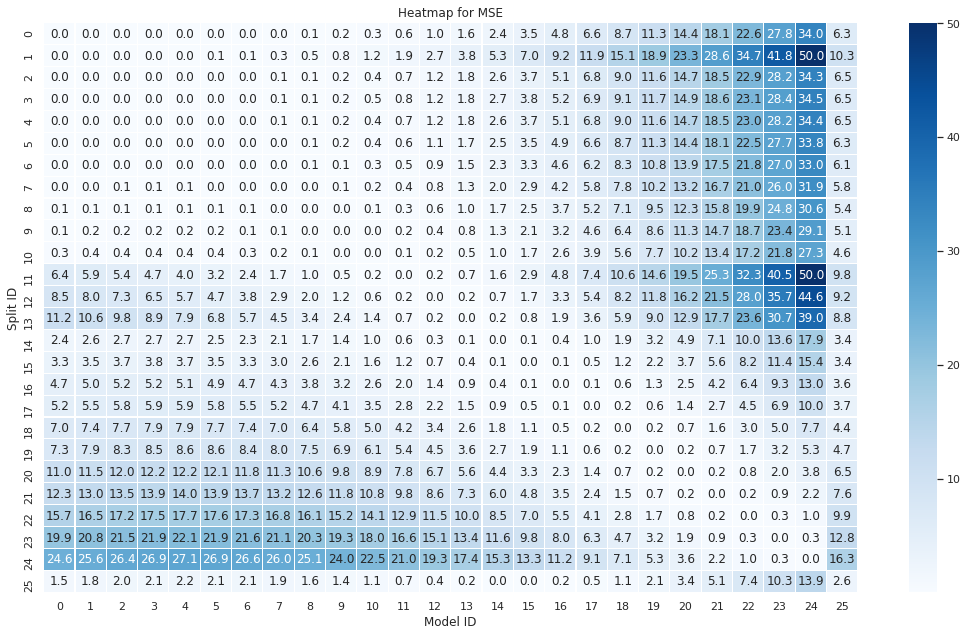

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)

matrix = info['mean_squared_error']

plot_heatmap(matrix=matrix, title=f'Heatmap for MSE', x_label='Model ID', y_label='Split ID', ax=ax,
             heatmap_kwargs=dict(linewidths=.1, cmap='Blues', annot=True, fmt='.1f'))
fig.tight_layout()

Note: The rightmost column and the lowest row refer respectively to the test set and to the model trained in the complete domain.

Note in the plot above that the farther from the partition the model was trained in, the greater the error that the model obtains in the prediction. For example, model 24 gets MSE of more than 50 for partition 1 while less than 1 for partition 24.